# Sen12MS Overview

A notebook to investigate regions and class distributions

Author: Marc Rußwurm

In [6]:
! pip install geopandas
! pip install contextily 

In [1]:
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import rasterio
import numpy as np
from pyproj import Proj, transform


root = "/workspace/app/data/sen12ms"

classes = [
    "Evergreen Needleleaf Forests",
    "Evergreen Broadleaf Forests",
    "Deciduous Needleleaf Forests",
    "Deciduous Broadleaf Forests",
    "Mixed Forests",
    "Closed (Dense) Shrublands",
    "Open (Sparse) Shrublands",
    "Woody Savannas",
    "Savannas",
    "Grasslands",
    "Permanent Wetlands",
    "Croplands",
    "Urban and Built-Up Lands",
    "Cropland/Natural Vegetation Mosaics",
    "Permanent Snow and Ice",
    "Barren",
    "Water Bodies"
]

## Iterate through files

In [2]:
tiles = pd.DataFrame(glob.glob(os.path.join(root,'*','*','*.tif')), columns=["path"])
split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
tiles = tiles.join(split)

In [5]:
tiles.shape

(541986, 6)

In [7]:
tiles.head()

,path,seed,season,sensor,region,tile
0,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p149.tif
1,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p510.tif
2,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p410.tif
3,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p362.tif
4,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p222.tif


## Read label tifs and store pixel histograms

In [8]:
pathtest = '/workspace/app/data/sen12ms/ROIs1868_summer/s1_126/ROIs1868_summer_s1_126_p121.tif'
with rasterio.open(pathtest, 'r') as src:
    arr = src.read(1)
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32654), 'transform': Affine(10.0, 0.0, 522909.09696999594,
       0.0, -10.0, 4775461.743080434)}


In [12]:
arr = arr +10

In [13]:
np.histogram(arr,bins=len(classes), range=(0,len(classes)))

(array([6287, 6577, 6378, 5824, 5246, 4445, 3580, 2970, 2376, 2938, 1397,
           0,    0,    0,    0,    0,    0]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17.], dtype=float32))

In [21]:
lc = tiles.loc[tiles["sensor"] == "s1"]
# lc = tiles.copy()

if os.path.exists(os.path.join(root,"histogram_test.csv")):
    histogram = pd.read_csv(os.path.join(root,"histogram_s.csv"), index_col=0)
else:
    def get_histogram(path):
        with rasterio.open(path, 'r') as src:
            arr = src.read(1)
        counts = np.histogram(arr,bins=len(classes), range=(0,len(classes)))[0]
        return dict(zip(classes,counts))

    histograms = lc["path"].apply(get_histogram)
    histogram = pd.DataFrame(histograms.to_list(), index=histograms.index)
    histogram = lc.join(histogram)
    histogram.to_csv(os.path.join(root,"histogram_eo.csv"))

In [44]:
histogram.iloc[0]

path                                   /workspace/app/utils/../data/sen12ms/ROIs2017_...
seed                                                                            ROIs2017
season                                                                            winter
sensor                                                                                lc
region                                                                               108
tile                                                                            p187.tif
Evergreen Needleleaf Forests                                                           0
Evergreen Broadleaf Forests                                                         3354
Deciduous Needleleaf Forests                                                           0
Deciduous Broadleaf Forests                                                            0
Mixed Forests                                                                          0
Closed (Dense) Shrubl

In [45]:
histogram.iloc[10000]

path                                   /workspace/app/utils/../data/sen12ms/ROIs2017_...
seed                                                                            ROIs2017
season                                                                            winter
sensor                                                                                lc
region                                                                                61
tile                                                                            p594.tif
Evergreen Needleleaf Forests                                                           0
Evergreen Broadleaf Forests                                                            0
Deciduous Needleleaf Forests                                                           0
Deciduous Broadleaf Forests                                                            0
Mixed Forests                                                                          0
Closed (Dense) Shrubl

In [42]:
histogram.columns

Index(['path', 'seed', 'season', 'sensor', 'region', 'tile',
       'Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests',
       'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests',
       'Mixed Forests', 'Closed (Dense) Shrublands',
       'Open (Sparse) Shrublands', 'Woody Savannas', 'Savannas', 'Grasslands',
       'Permanent Wetlands', 'Croplands', 'Urban and Built-Up Lands',
       'Cropland/Natural Vegetation Mosaics', 'Permanent Snow and Ice',
       'Barren', 'Water Bodies'],
      dtype='object')

In [20]:
histogram["region"].unique().shape

(125,)

## Class Distribution by Region

In [21]:
histogram_per_region.reset_index()

NameError: name 'histogram_per_region' is not defined

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


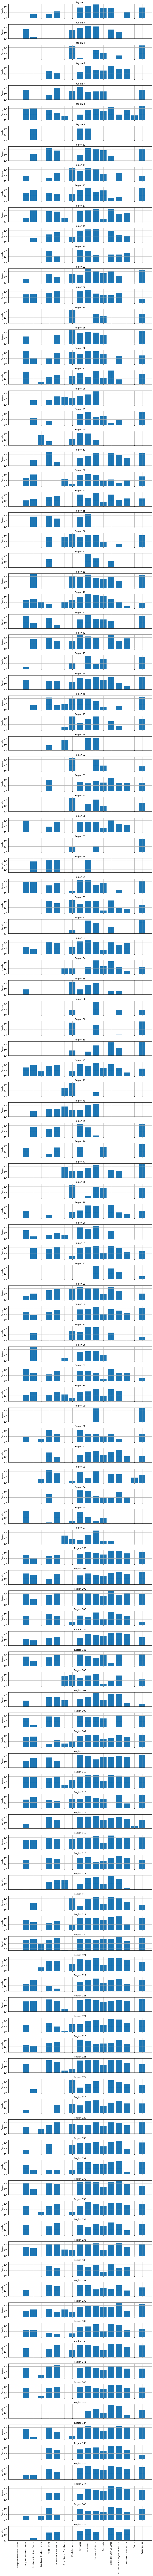

In [22]:
histogram_per_region = histogram.groupby("region").sum()[classes]
regions = histogram["region"].unique()

fig,axs = plt.subplots(125,1,figsize=(12,200),sharex=True)

ax = axs[0]
for ax,i in zip(axs,range(len(axs))):
    d = histogram_per_region.iloc[i]
    ax.bar(d.index, d.values)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_yscale('log')
    ax.set_yticks([1e3,1e5,1e7])
    ax.set_ylim(0,1e8)
    ax.set_title(f"Region {d.name}")
    ax.set_ylabel("#pixels")

for tick in axs[-1].get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Class Distribution by Season

In [23]:
histogram_per_season = histogram.groupby("season").sum()[classes]
histogram_per_season

,Evergreen Needleleaf Forests,Evergreen Broadleaf Forests,Deciduous Needleleaf Forests,Deciduous Broadleaf Forests,Mixed Forests,Closed (Dense) Shrublands,Open (Sparse) Shrublands,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Croplands,Urban and Built-Up Lands,Cropland/Natural Vegetation Mosaics,Permanent Snow and Ice,Barren,Water Bodies
season,,,,,,,,,,,,,,,,,
fall,0,83839642,43617668,3560311,150672682,133597429,4499676,199361877,358062171,669014208,729932388,36493556,523771829,467440076,51666375,0,620874848
spring,0,35169562,114461610,8516,173018642,91931871,15266338,59174553,177388877,518445158,439273502,31064884,507802578,335295405,42061406,37774,138907612
summer,0,112225353,72256764,169358,95694584,92747751,4191100,329951824,190202725,390660003,453501643,47826052,554675319,253557557,44252461,69000,356487114
winter,0,22716466,21227068,17040,56328271,37736204,5380494,199318230,198032873,293436811,364911473,14589735,356417509,203520997,36375618,0,275674411


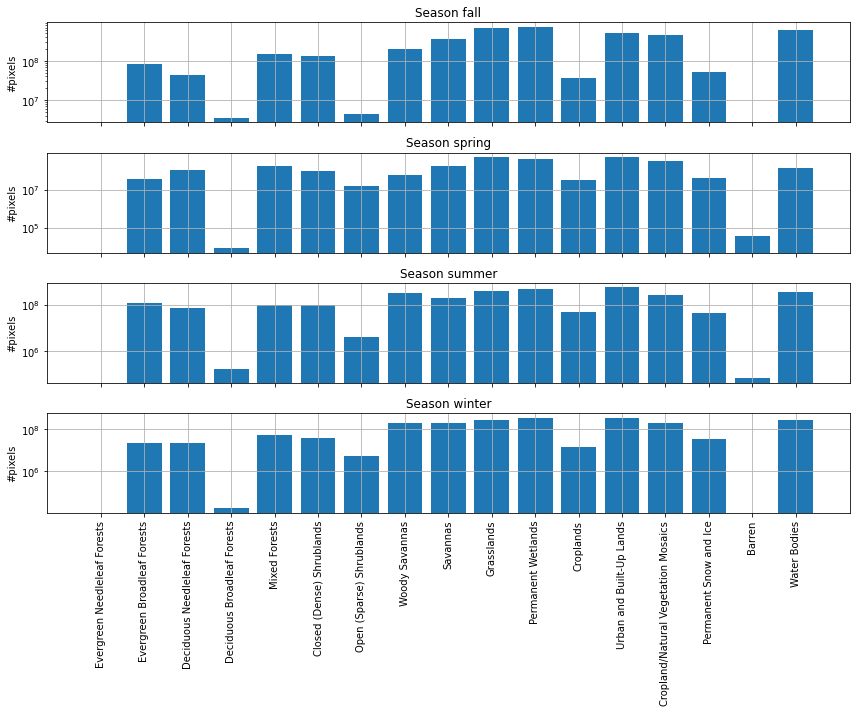

In [24]:
histogram_per_season = histogram.groupby("season").sum()[classes]
regions = histogram["region"].unique()

fig,axs = plt.subplots(4,1,figsize=(12,10),sharex=True)

ax = axs[0]
for ax,i in zip(axs,range(len(axs))):
    d = histogram_per_season.iloc[i]
    ax.bar(d.index, d.values)
    ax.xaxis.grid()
    ax.yaxis.grid()
    ax.set_yscale('log')
    #ax.set_yticks([1e3,1e5,1e7])
    #ax.set_ylim(0,1e8)
    ax.set_title(f"Season {d.name}")
    ax.set_ylabel("#pixels")


for tick in axs[-1].get_xticklabels():
    tick.set_rotation(90)

    
fig.tight_layout()

## Total Class Distribution

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


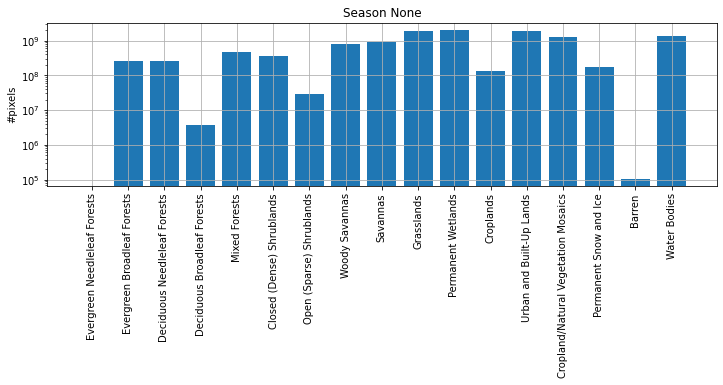

In [23]:
total = histogram[classes].sum(0)

fig,ax = plt.subplots(1,1,figsize=(12,3))

d = total
ax.bar(d.index, d.values)
ax.xaxis.grid()
ax.yaxis.grid()
ax.set_yscale('log')
#ax.set_yticks([1e3,1e5,1e7])
#ax.set_ylim(0,1e8)
ax.set_title(f"Season {d.name}")
ax.set_ylabel("#pixels")

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    
fig.tight_layout()

## Get region location

In [25]:
def get_xy(path):
    with rasterio.open(path, 'r') as src:
        trafo = src.transform
        crs = src.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)

    return x,y

regions = lc.groupby("region").first()
xy = pd.DataFrame.from_records(regions["path"].apply(get_xy), columns=["x","y"])
regions = regions.reset_index().join(xy)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string("

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string("

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD 

In [26]:
regions

,region,path,seed,season,sensor,tile,x,y
0,1,/workspace/app/data/sen12ms/ROIs1970_fall/s2_1...,ROIs1970,fall,s2,p153.tif,-114.036821,42.139752
1,100,/workspace/app/data/sen12ms/ROIs1868_summer/lc...,ROIs1868,summer,lc,p101.tif,28.898610,40.418742
2,101,/workspace/app/data/sen12ms/ROIs1868_summer/lc...,ROIs1868,summer,lc,p566.tif,-87.356746,41.591007
3,102,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,p485.tif,0.249020,52.278377
4,103,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,p859.tif,17.451344,48.825707
...,...,...,...,...,...,...,...,...
120,91,/workspace/app/data/sen12ms/ROIs1970_fall/lc_9...,ROIs1970,fall,lc,p858.tif,19.188883,47.382825
121,93,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,p801.tif,47.876733,38.291084
122,94,/workspace/app/data/sen12ms/ROIs2017_winter/s2...,ROIs2017,winter,s2,p823.tif,-80.246104,35.838118
123,95,/workspace/app/data/sen12ms/ROIs1868_summer/lc...,ROIs1868,summer,lc,p119.tif,60.643517,61.863218


## Plot region location

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


(-20026376.39, 20026376.39, -10000000.0, 15000000.0)

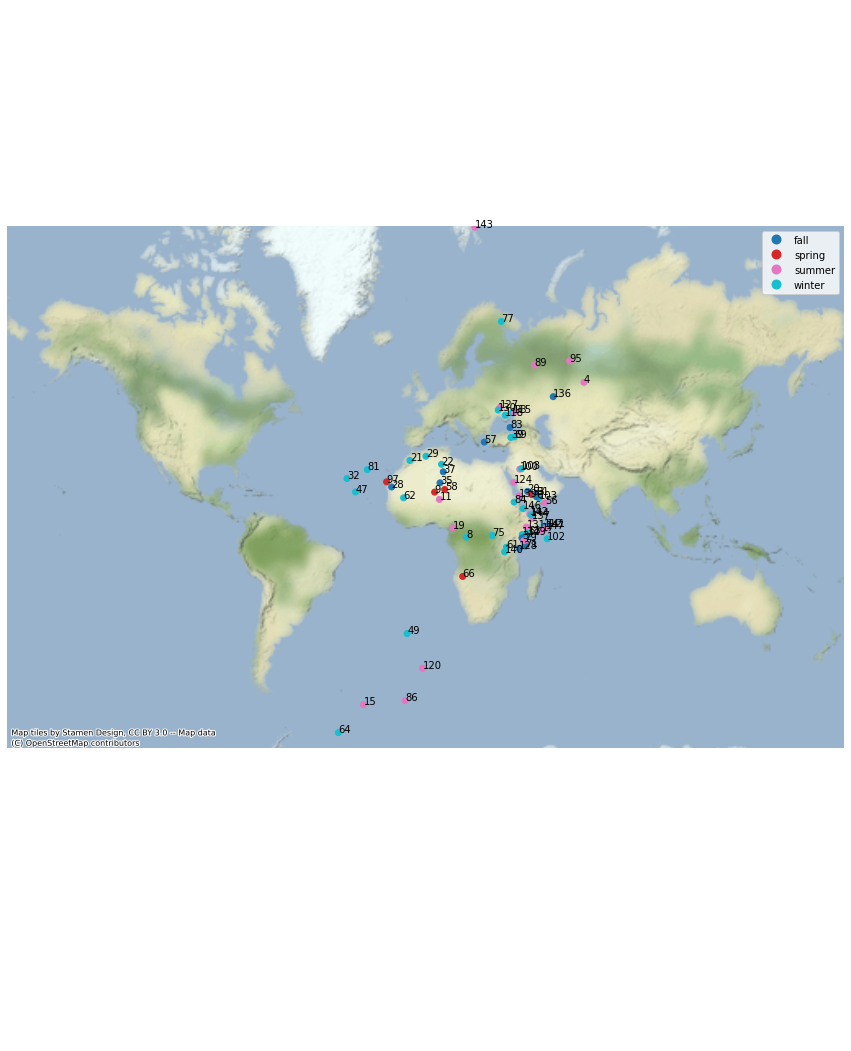

In [27]:
gdf = gpd.GeoDataFrame(regions, geometry=gpd.points_from_xy(regions.y, regions.x),crs=4326).to_crs(epsg=3857)

fig,ax=plt.subplots(figsize=(15,16))
gdf.plot(ax=ax,column="season",legend=True)
# ax.scatter(gdf.geometry.x,gdf.geometry.y, c=gdf.season)
ctx.add_basemap(ax, url=ctx.providers.Stamen.TerrainBackground,zoom=1)

for x,y,region in zip(gdf.geometry.x,gdf.geometry.y,gdf.region):
    ax.annotate(region,(x,y))

ax.set_xlim(-20026376.39,20026376.39)
ax.set_ylim(-1e7, 1.5e7)
ax.axis('off')

## Save shapefile

In [9]:
gdf.to_file("regions.shp")

## Ploting images

In [23]:
def plot_image(img_path):
    imf = rasterio.open(img_path)

    print(imf.meta)
    print(imf.bounds)
    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    print(x,y)
    print('Image Size: ',image_array.shape)
    ni = image_array.shape[0]
    fig = plt.figure(figsize=(15,10))

    for i in range(ni):
        plt.subplots_adjust(hspace=.1)
        plt.subplot(1,ni,i+1)
        plt.imshow(image_array[i],interpolation='nearest',cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title('Band '+str(i+1), fontsize=14)

In [36]:
CRS.from_epsg(32654)

NameError: name 'CRS' is not defined

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
-70.21966862779055 -37.11386450296634
Image Size:  (2, 256, 256)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 390358.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=390358.4708795169, bottom=5889240.150648338, right=392918.4708795169, top=5891800.150648338)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

-70.23407270468559 -37.11371543361142
Image Size:  (2, 256, 256)


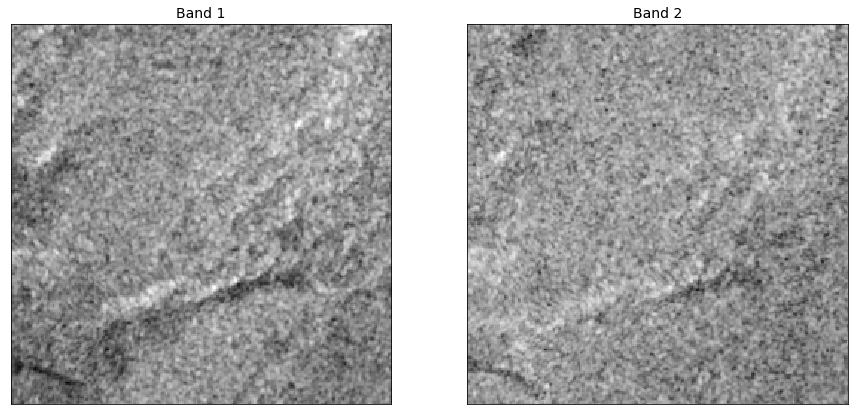

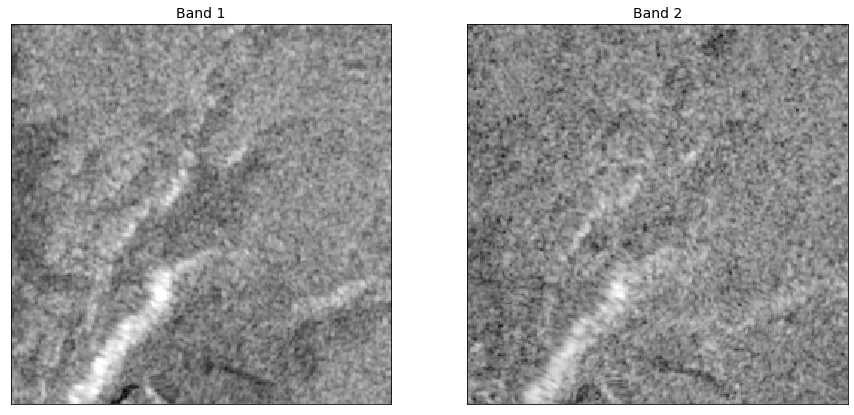

In [61]:
# img_path = '/workspace/app/data/sen12ms/ROIs1868_summer/lc_126/ROIs1868_summer_lc_126_p121.tif'
# plot_image(img_path)

 
img_path = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p426.tif'
plot_image(img_path)
img_path = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p425.tif'
plot_image(img_path)
# img_path = '/workspace/app/data/sen12ms/ROIs1868_summer/s2_126/ROIs1868_summer_s2_126_p121.tif'
# plot_image(img_path)


## Clossest Distance

In [43]:
# Calculating the distance between two points with their coordinates
import math as m
def distance(lat1,lon1,lat0,lon0):
    r = 6371.0 # in km
    lat0 = float(lat0)*m.pi/180.0
    lon0 = float(lon0)*m.pi/180.0
    lat1 = float(lat1)*m.pi/180.0
    lon1 = float(lon1)*m.pi/180.0
  
    a = m.sin(0.5*(lat1-lat0))**2 + m.cos(lat0)*m.cos(lat1)*m.sin(0.5*(lon1-lon0))**2
    c = 2.0*m.atan2(m.sqrt(a),m.sqrt(1-a))

    return r*c

In [26]:
def get_xy(img_path):
    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    
    return (x,y)

In [20]:
regions_list = tiles['region'].unique()

region_select = tiles[(tiles['region'] == '55') & (tiles['sensor'] == 's1')]

region_select

,path,seed,season,sensor,region,tile
0,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p149.tif
1,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p510.tif
2,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p410.tif
3,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p362.tif
4,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p222.tif
...,...,...,...,...,...,...
96635,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p62.tif
96636,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p799.tif
96637,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p461.tif
96638,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p246.tif


In [110]:
xy = pd.DataFrame.from_records(region_select["path"].apply(get_xy), columns=["x","y"])
regions_xy = region_select.reset_index().join(xy)
regions_xy 

,index,path,seed,season,sensor,region,tile,x,y
0,0,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p149.tif,-70.448146,-37.007458
1,1,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p510.tif,-70.263456,-37.148018
2,2,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p410.tif,-70.450120,-37.111269
3,3,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p362.tif,-70.305695,-37.089873
4,4,/workspace/app/data/sen12ms/ROIs2017_winter/s1...,ROIs2017,winter,s1,55,p222.tif,-70.232765,-37.032966
...,...,...,...,...,...,...,...,...,...
1311,96635,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p62.tif,134.217147,-30.593248
1312,96636,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p799.tif,134.375494,-30.882851
1313,96637,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p461.tif,134.510108,-30.744832
1314,96638,/workspace/app/data/sen12ms/ROIs1868_summer/s1...,ROIs1868,summer,s1,55,p246.tif,134.350189,-30.663281


In [48]:
np.array(xy['y'])

array([-37.00745761, -37.14801826, -37.11126949, ..., -30.74483247,
       -30.66328086, -30.5814519 ])

In [60]:
yy = np.array(xy['y'])
xx = np.array(xy['x'])
for i in regions_xy.index:
    xo = regions_xy['x'][i]
    yo = regions_xy['y'][i]
    print(xo,yo)
    xyd = np.array([distance(yy[j],xx[j],yo,xo) for j in regions_xy.index])
    xyd[i] = 9.99999990e+20
    print(xyd.argmin(),xyd.min())
    print(regions_xy['path'][i],regions_xy['path'][xyd.argmin()])
    if i == 10:
        break
    

-70.44814559737713 -37.007457608489645
597 1.2772646318626704
/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p149.tif /workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p148.tif
-70.26345582049775 -37.14801825778602
58 1.2773176830414064
/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p510.tif /workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p509.tif
-70.4501203676489 -37.11126949431806
343 1.2772571756182707
/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p410.tif /workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p409.tif
-70.30569539349084 -37.08987331258219
399 1.2773080597573954
/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p362.tif /workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p361.tif
-70.23276470708373 -37.0329659090471
573 1.2773348992639877
/workspace/app/data/sen12ms/ROIs2017_winter/s1_55

In [74]:
from matplotlib.patches import Rectangle

def only_bounds(img_path):
    imf = rasterio.open(img_path)
    return imf.bounds

(5887240.150648338, 5893800.150648338)

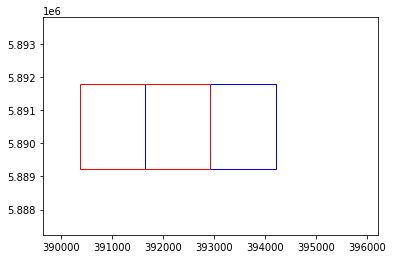

In [109]:
img_path1 = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p426.tif'
img_path2 = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p425.tif'
p1 = only_bounds(img_path1)
p2 = only_bounds(img_path2)

fig, ax = plt.subplots()

ax.add_patch(Rectangle((p1.left, p1.top), p1.right-p1.left, p1.bottom-p1.top,fill=False,edgecolor = 'blue'))
ax.add_patch(Rectangle((p2.left, p2.top), p2.right-p2.left, p2.bottom-p2.top,fill=False,edgecolor = 'red'))

ax.set_xlim([p1.left-2000,p1.right+2000])
ax.set_ylim([p1.bottom-2000,p1.top+2000])